In [2]:
import io

from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv

import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [3]:
load_dotenv()
credential = DefaultAzureCredential()

## Load Data

In [4]:
STORAGE_ACCOUNT_NAME = "uscgeneralsa"
CONTAINER_NAME = "mlops-demo"
BLOB_NAME = "data/raw/yelp_labelled.txt"


blob_service_client = BlobServiceClient(
    account_url=f"https://{STORAGE_ACCOUNT_NAME}.blob.core.windows.net",
    credential=credential
)

blob_client = blob_service_client.get_blob_client(container=CONTAINER_NAME, blob=BLOB_NAME)
bytes = blob_client.download_blob().readall()

data = pd.read_csv(io.BytesIO(bytes), delimiter="\t", names=["text", "label"])

## Exploration

In [5]:
data

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [6]:
data["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

<Axes: >

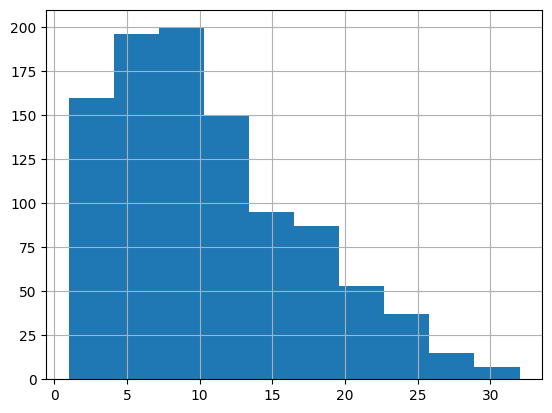

In [7]:
data["text"].str.split().str.len().hist()

In [8]:
def lexical_diversity(text):
    n_words = len(text.split())
    n_unique_words = len(set(text.split()))
    return n_unique_words / n_words

<Axes: >

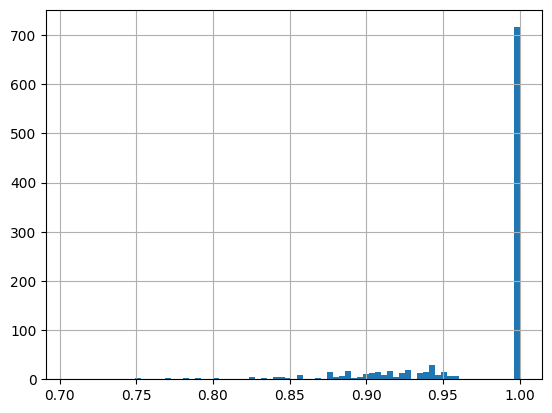

In [9]:
data["text"].apply(lexical_diversity).hist(bins=75)

## Preprocessing

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [12]:
text_clean = []

for doc in nlp.pipe(
    texts=data["text"].tolist(),
    disable=["ner"]
):
    
    lemmas = []
    
    for token in doc:

        # accessing the attributes of tokens to filter out stop words and punctuation
        if not any([token.is_stop, token.is_punct]):

            # accessing lemmas of tokens to create list of lemmas
            lemmas.append(token.lemma_.lower())
            
    text_clean.append(" ".join(lemmas))

In [13]:
data["text_clean"] = text_clean

In [14]:
data.head()

,text,label,text_clean
0,Wow... Loved this place.,1,wow love place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,stop late bank holiday rick steve recommendati...
4,The selection on the menu was great and so wer...,1,selection menu great price


In [15]:
X_train, X_test, y_train, y_test = train_test_split(data["text_clean"], data["label"], train_size=0.80)

In [16]:
X_train

379    staff friendly wait time serve horrible say hi...
637    prove dead wrong sushi bar quality great servi...
611                check place couple year ago impressed
195                            good place tasty bowl pho
382        service outshine definitely recommend halibut
                             ...                        
196                      live music fridays totally blow
964                 del taco pretty nasty avoid possible
735                              probably come recommend
730           food barely lukewarm sit wait server bring
781                        join club awesome offer email
Name: text_clean, Length: 800, dtype: object

## Training

In [17]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),  # Placeholder for vectorizer, replaced in grid search
    ('classifier', LogisticRegression())  # Placeholder for classifier, replaced in grid search
])

In [18]:
param_grid = [
    {
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],  # Test CountVectorizer and TfidfVectorizer
        'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
        'classifier': [LogisticRegression()],  # Logistic Regression
        'classifier__C': [0.1, 1, 10],  # Regularization strength for Logistic Regression
    },
    {
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [MultinomialNB()],  # Multinomial Naive Bayes
        'classifier__alpha': [0.1, 1, 10],  # Smoothing parameter for Naive Bayes
    }
]

In [19]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

In [20]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=TfidfVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=TfidfVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=TfidfVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, vectorizer=TfidfVectorize

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10],
                          'vectorizer': [CountVectorizer(), TfidfVectorizer()],
                          'vectorizer__ngram_range': [(1, 1), (1, 2)]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 1, 10],
                          'vectorizer': [CountVectorizer(), TfidfVectorizer()],
                          'vectorizer__ngram_range': [(1, 1), (1, 2)]}],
             scoring='accuracy', verbose=2)

In [22]:
type(grid_search)

sklearn.model_selection._search.GridSearchCV

In [ ]:
search_results = grid_search.cv_results_

rows = zip(
    search_results["rank_test_score"],
    search_results["params"],
    search_results["mean_test_score"],
    search_results["std_test_score"],
)

sorted_rows = sorted(rows, key=lambda x: x[0])

# Print the sorted rows
print(f"{'Rank':<6}{'Mean Test Score':<20}{'Std Test Score':<20}{'Parameters':<150}")
print("-" * 200)
for _, (rank, params, mean_score, std_score) in enumerate(sorted_rows, start=1):
    print(f"{rank:<6}{mean_score:<20.3f}{std_score:<20.3f}{params}")

Rank  Mean Test Score     Std Test Score      Parameters                                                                                                                                            
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1     0.808               0.031               {'classifier': MultinomialNB(), 'classifier__alpha': 10, 'vectorizer': TfidfVectorizer(), 'vectorizer__ngram_range': (1, 2)}
2     0.805               0.038               {'classifier': LogisticRegression(), 'classifier__C': 1, 'vectorizer': CountVectorizer(), 'vectorizer__ngram_range': (1, 2)}
3     0.802               0.031               {'classifier': MultinomialNB(), 'classifier__alpha': 10, 'vectorizer': CountVectorizer(), 'vectorizer__ngram_range': (1, 2)}
3     0.802               0.021               {'classifier': MultinomialNB(), 'classifier

In [23]:
grid_search.best_estimator_

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier', LogisticRegression(C=10))])

In [50]:
print(grid_search.best_params_)

{'classifier': MultinomialNB(), 'classifier__alpha': 10, 'vectorizer': TfidfVectorizer(), 'vectorizer__ngram_range': (1, 2)}


In [28]:
print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'classifier': MultinomialNB(), 'classifier__alpha': 10, 'vectorizer': TfidfVectorizer(), 'vectorizer__ngram_range': (1, 2)}


In [52]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        96
           1       0.81      0.78      0.79       104

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



In [ ]:
s